In [1]:
import sys
sys.path.insert(0, '../pyLDLE2/')

In [2]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf
from matplotlib import pyplot as plt
from scipy.sparse.linalg import eigsh
from scipy.stats import chi2
from sklearn.decomposition import PCA

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [3]:
vis = visualize_.Visualize()

In [22]:
#X, labelsMat, ddX = datasets.Datasets().circular_disk(RES=50, noise=0.0025, noise_type='normal')
X, labelsMat, ddX = datasets.Datasets().circular_disk_uniform(n=10000, noise=0.05, noise_type='uniform')

X.shape =  (7837, 3)


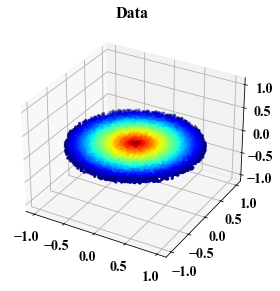

In [23]:
vis.data(X, ddX)

In [24]:
k_nn = 128
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

In [25]:
h_cand = np.sqrt(2)*neigh_dist[:,-1]/np.sqrt(chi2.ppf(0.99, df=2))
print(np.min(h_cand), np.median(h_cand), np.max(h_cand))
h = np.min(h_cand)
K = np.exp(-neigh_dist**2/h**2)

0.05478889615756535 0.06294012852988615 0.09664777581482674


In [26]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [27]:
mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    temp = X-X[i,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))

mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    X_i_nbrs = X[neigh_ind[i,:].tolist()+[i],:]
    pca = PCA(n_components=2)
    y = pca.fit_transform(X_i_nbrs)
    X_rec = pca.inverse_transform(y)
    temp = X_rec[:-1,:] - X_rec[-1,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i)[0,neigh_ind[i,:]].dot(temp))
    
    
# mu_hN_norm = np.zeros(X.shape[0])
# #np.random.seed(42)
# #v0 = np.random.uniform(0,1,X.shape[0])
# #_, Y = eigsh(K, k=200, v0=v0, which='LM')
# for i in range(X.shape[0]):
#     X_ = X - X[i,:][None,:]
#     Ki = K.getrow(i)
#     indices = Ki.indices.tolist()
#     K_ = Ki.data
#     temp2 = 0
#     Xi = X[i,:]
#     for ji in range(len(indices)):
#         j = indices[ji]
#         for jpi in range(len(indices)):
#             jp = indices[jpi]
#             temp2 += K_[ji]*K_[jpi]*(X_[j,:][:,None]).dot(X_[jp,:][None,:])
            
#     lmbda, _ = eigsh(temp2, k=2)
#     #mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))
#     mu_hN_norm[i] = np.sqrt(np.sum(lmbda))

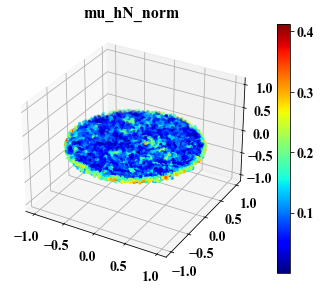

In [28]:
vis.data(X, mu_hN_norm, title='mu_hN_norm', colorbar=True)

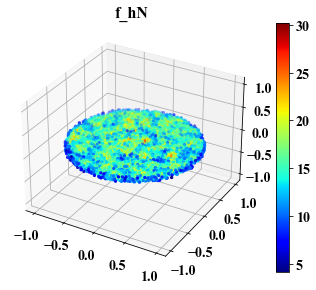

In [29]:
vis.data(X, np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

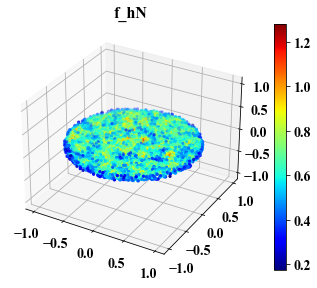

In [30]:
vis.data(X, np.array(K.sum(axis=1)).flatten()/(n*h**2), title='f_hN', colorbar=True)

In [31]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

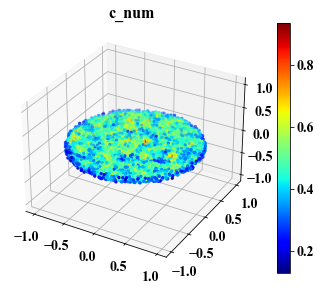

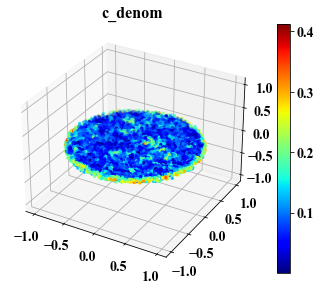

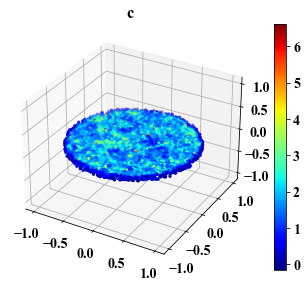

In [32]:
vis.data(X, c_num, title='c_num', colorbar=True)
vis.data(X, c_denom, title='c_denom', colorbar=True)
vis.data(X, np.log(c), title='c', colorbar=True)

In [33]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [34]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

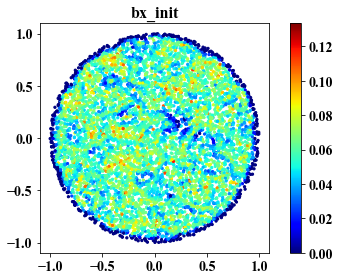

In [35]:
vis.data(X[:,:2], bx_init, title='bx_init', colorbar=True)

In [36]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=5000)

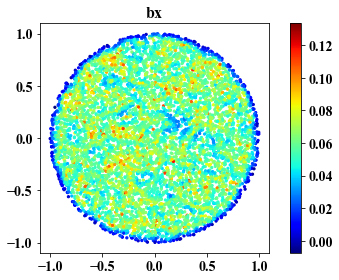

In [37]:
vis.data(X[:,:2], bx, title='bx', colorbar=True)

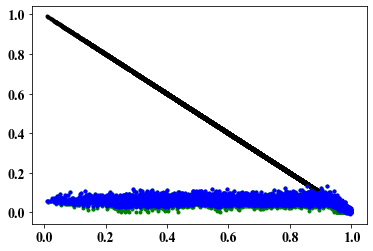

In [38]:
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx_init, color='g', label='init $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')

(-0.04056797641817807,
 1.04952933464982,
 -0.05731010273018926,
 1.04093848918391)

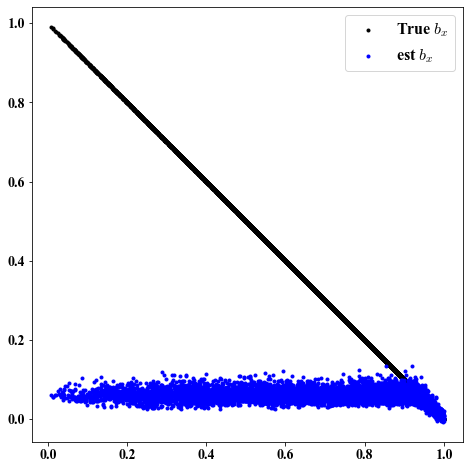

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.legend()
plt.axis('image')

In [41]:
m0_1 = 0.5*(1+erf(bx/h))

In [42]:
q3 =  (np.pi**(-2/2))*np.array(K.sum(axis=1)).flatten()/((n-1)*h**2)
q4 =  (np.pi**(-2/2))*np.array(K.sum(axis=1)).flatten()/(m0_1*((n-1)*h**2))

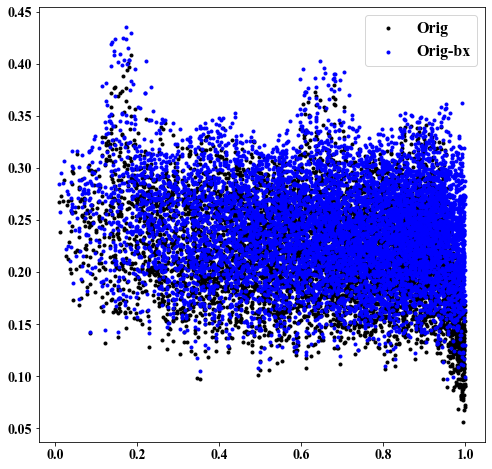

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), q3, color='k', label='Orig')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), q4, color='b', label='Orig-bx')
plt.legend()